# Bye-Bayes Network project
## Introduction
The aim of the proposed project is to analyze the set of reasons that lead people of all ages and sexes to death.
The probabilities relating to the events have been extrapolated from official documents that can be consulted at the following links according to the specific category of event:
<ol>
    <li>  <b>Most of the probabilities:</b> <a>https://www.thelancet.com/cms/10.1016/S0140-6736(18)32203-7/attachment/0aaa0b77-f3e8-452c-a5c6-4debeaeae82d/mmc2.pdf</a></br>
    <b>And the related study:</b> <a>https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(18)32203-7/fulltext</a>;
    <li>  <b>Probability of fall:</b> <a>https://injuryprevention.bmj.com/content/injuryprev/11/2/115.full.pdf</a>;
    <li>  <b>Probability of natural disasters:</b> <a>https://ourworldindata.org/natural-disasters</a>;
    <li>  <b>Probability of poisoning:</b> <a>https://www.poison.org/poison-statistics-national</a>;
    <li>  <b>Probability of self-harm:</b> <a>https://ourworldindata.org/suicide</a>;
    <li>  <b>Probability of malignancy (neoplasms):</b> <a>https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4544764/</a>;
    <li>  <b>Probability of respiratory infections:</b> <a>https://onlinelibrary.wiley.com/doi/epdf/10.1111/irv.12639</a>;
    <li>  <b>Probability of cardiovascular disease:</b> <a>https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7847085/</a>;
    <li>  <b>Correlation between cardiovascular disease and possibility of fall:</b> <a>https://www.ahajournals.org/doi/full/10.1161/HCQ.0000000000000108?rfr_dat=cr_pub++0pubmed&url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org</a>;
    <li>  <b>Study about Covid-19 infectivity and relation with respiratory infections:</b> <a>https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2777314</a>;
</ol>

In particular, from the study in the first element of the list we have collected the possibilities of suffering fatal damage from one of the causes, while the following links refer to the chances of single unfortunate events taking place.

In [37]:
import pgmpy as pg
from pgmpy.readwrite import BIFReader
import networkx as nx
from pgmpy.models import BayesianModel, BayesianNetwork
from networkx.drawing.nx_pydot import graphviz_layout
import pydot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pgmpy.estimators import HillClimbSearch, K2Score, ExhaustiveSearch, BicScore, BDeuScore, BDsScore, MmhcEstimator, BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import itertools

In [70]:
# Graph printing and png creation

def draw_graph(model,name,color="green", title=""):
    p = graphviz_layout(model, prog="dot")
    plt.figure(figsize=(15, 8))
    nx.draw(model, with_labels=True, pos=p, node_size=1400, node_color=color, font_size=6)
    if title != "":
        plt.title(title)
    plt.savefig(name+'.png')
    plt.show()

## Models
Here are the two main models we rely on within the project, both built manually. </br>
The difference between the two models is that in the second an extra "Covid" node was added to analyze the variations that the spread of SARS-CoV-2 has brought in the area of ​​respiratory tract infections and number of deaths.

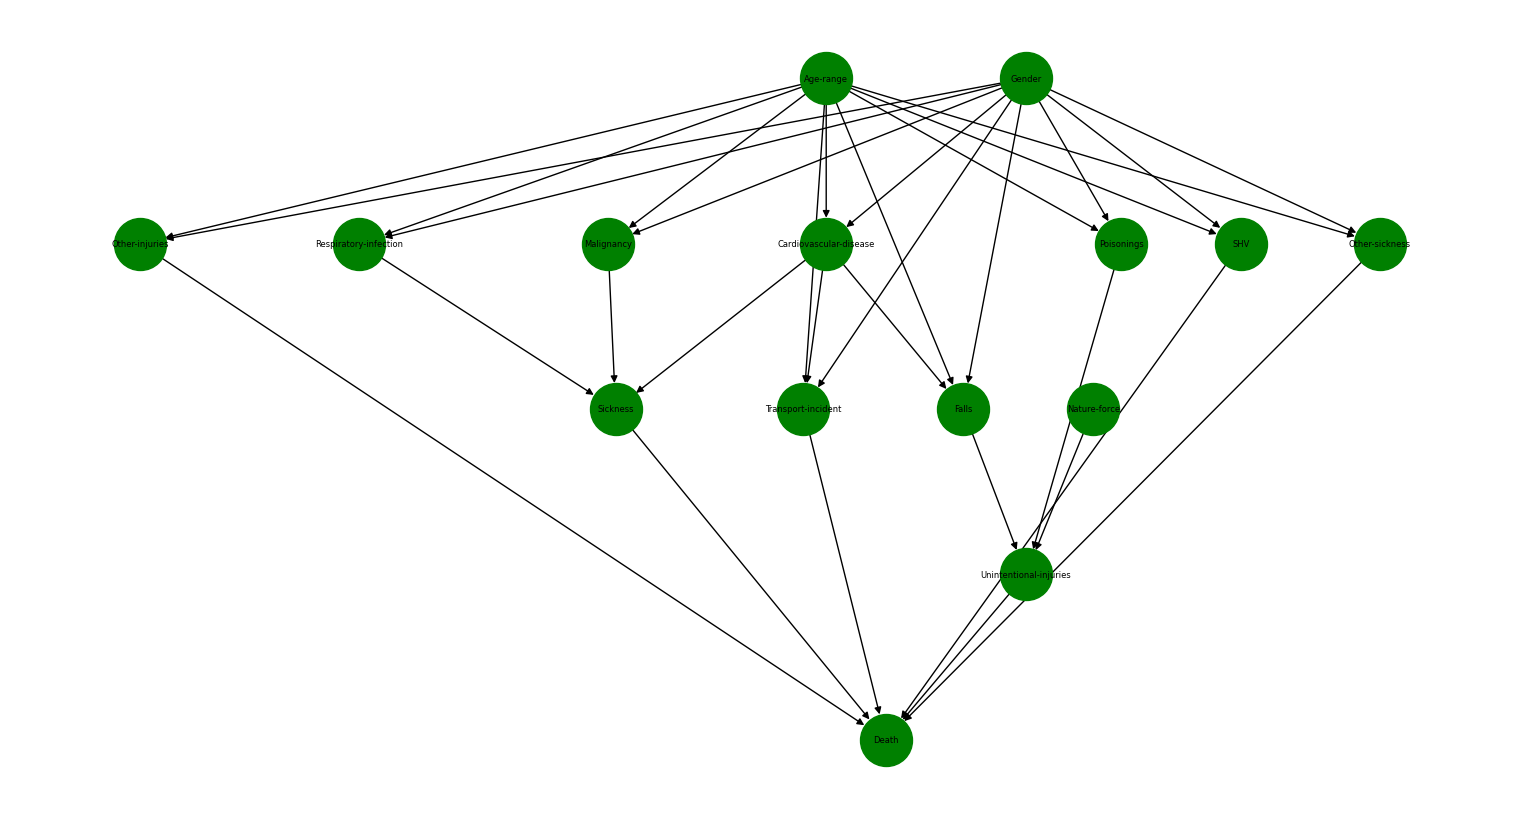

In [39]:
# Manual constructed model

mc_model = BayesianNetwork([
    ('Age-range', 'Other-injuries'), ('Age-range', 'Falls'), ('Age-range', 'Poisonings'), ('Age-range', 'Transport-incident'), ('Age-range', 'SHV'),
    ('Age-range', 'Respiratory-infection'), ('Age-range', 'Malignancy'), ('Age-range', 'Other-sickness'), ('Age-range', 'Cardiovascular-disease'),
    ('Gender', 'Other-injuries'), ('Gender', 'Falls'), ('Gender', 'Poisonings'), ('Gender', 'Transport-incident'), ('Gender', 'SHV'), 
    ('Gender', 'Respiratory-infection'), ('Gender', 'Malignancy'), ('Gender', 'Other-sickness'), ('Gender', 'Cardiovascular-disease'),
    ('Cardiovascular-disease', 'Falls'), ('Cardiovascular-disease', 'Transport-incident'), ('Cardiovascular-disease', 'Sickness'), 
    ('Other-injuries', 'Death'), ('Unintentional-injuries', 'Death'), ('Falls', 'Unintentional-injuries'), ('Poisonings', 'Unintentional-injuries'), 
    ('Nature-force', 'Unintentional-injuries'), ('Transport-incident', 'Death'), ('SHV', 'Death'), ('Respiratory-infection', 'Sickness'), 
    ('Malignancy', 'Sickness'), ('Other-sickness', 'Death'), ('Sickness', 'Death')
])

draw_graph(mc_model,"mc_model")

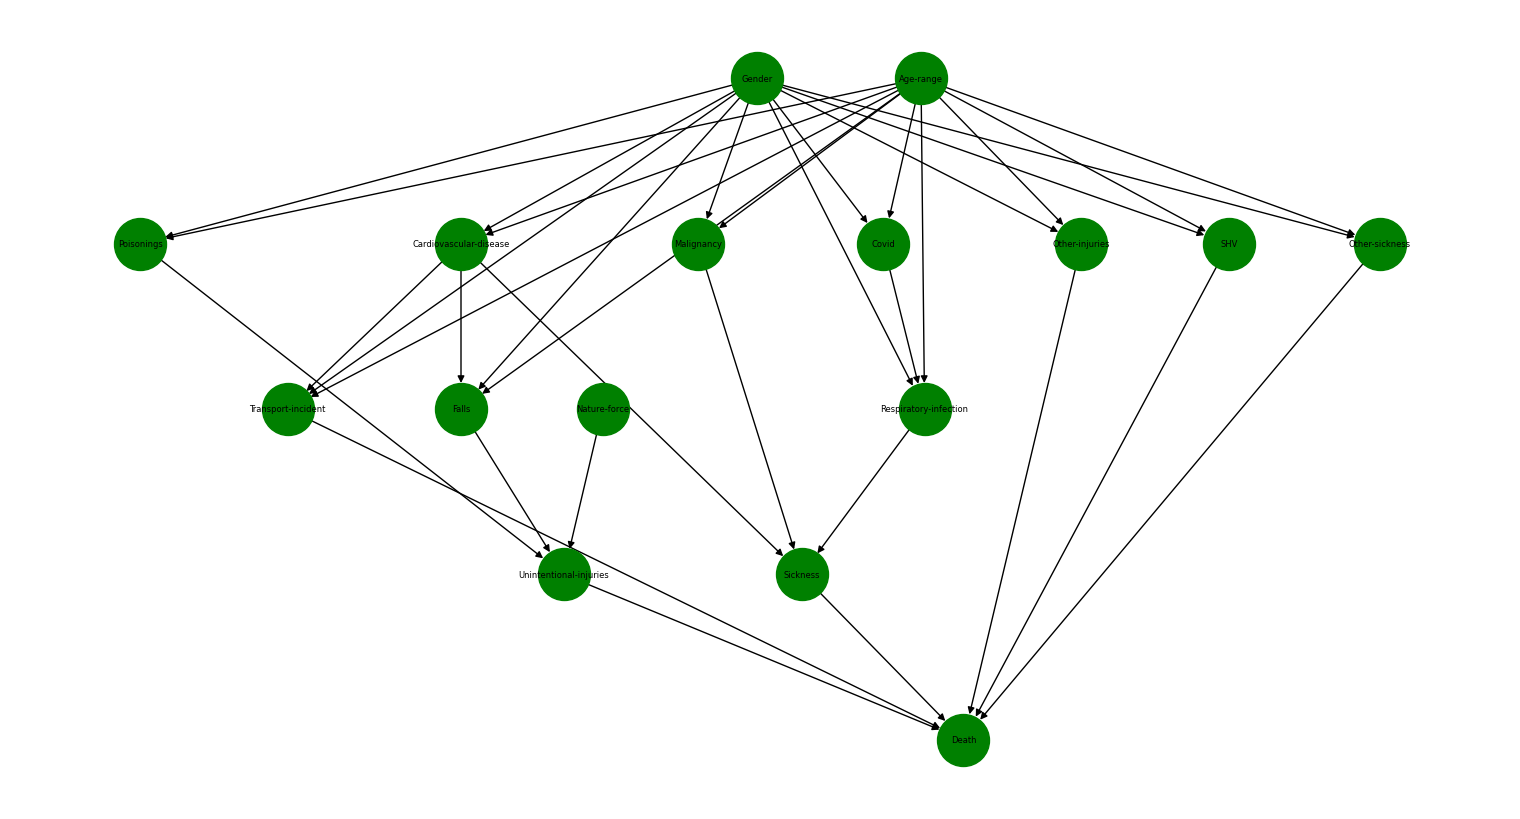

In [40]:
# Manual constructed model with "Covid" node

mc_model_Covid = BayesianNetwork([
    ('Age-range', 'Other-injuries'), ('Age-range', 'Falls'), ('Age-range', 'Poisonings'), ('Age-range', 'Transport-incident'), ('Age-range', 'SHV'),
    ('Age-range', 'Respiratory-infection'), ('Age-range', 'Malignancy'), ('Age-range', 'Other-sickness'), ('Age-range', 'Cardiovascular-disease'),
    ('Age-range', 'Covid'), ('Gender', 'Other-injuries'), ('Gender', 'Falls'), ('Gender', 'Poisonings'), ('Gender', 'Transport-incident'),
    ('Gender', 'SHV'), ('Gender', 'Respiratory-infection'), ('Gender', 'Malignancy'), ('Gender', 'Other-sickness'), ('Gender', 'Cardiovascular-disease'),
    ('Gender', 'Covid'), ('Covid', 'Respiratory-infection'), ('Cardiovascular-disease', 'Falls'), ('Cardiovascular-disease', 'Transport-incident'), 
    ('Cardiovascular-disease', 'Sickness'), ('Other-injuries', 'Death'), ('Unintentional-injuries', 'Death'), ('Falls', 'Unintentional-injuries'),
    ('Poisonings', 'Unintentional-injuries'), ('Nature-force', 'Unintentional-injuries'), ('Transport-incident', 'Death'),
    ('SHV', 'Death'), ('Respiratory-infection', 'Sickness'), ('Malignancy', 'Sickness'), ('Other-sickness', 'Death'), ('Sickness', 'Death')
])

draw_graph(mc_model_Covid,"mc_model_Covid")

In [41]:
# Data retrieving using Bif files

data = BIFReader("./data/probabilities.bif")
data_plus_covid = BIFReader("./data/probabilities_plus_Covid.bif")

## Dataset

The dataset used could be found in "./data/dataset.csv" and it is composed of 1 milion rows. In the dataset there is a distinction between something that can happen (4-) to a person and something that had serious consequences to the person. Each row containing informations about:
1. ID: a unique identifier of the row
2. Age-range:
    - young if age is between 0-14
    - adult if age is between 15-70
    - old if age is 70+
3. Gender: male or female
4. Respiratory infection: 1 if the person contracted a respiratory infection, 0 otherwise
5. Malignancy: 1 if the person contracted a malignancy, 0 otherwise
6. Cardio-vascular disease: 1 if the person has been affected by a cardio-vascular diseases, 0 otherwise
7. Poisonings: 1 if the person has been poisoned during the year, 0 otherwise
8. SHV (Self-harm violence): 1 if the person has been victim of self-harm violence, 0 otherwise
9. Falls: 1 if person has fallen during the year, 0 otherwise
10. Nature Force: 1 if the person has been victim of natural disasters, 0 otherwise
11. Transport incident: 1 if the person has been victim of a transport incident, 0 otherwise

12. Other injuries: 1 if the person has been victim of other, not tracked, injuries that had serious consequences on the person's health, 0 otherwise
13. Other sickess: 1 if the person suffered from other, not tracked, sickensses that had serious consequences on the person's health, 0 otherwise
14. Sickness: 1 if something among respiratory-infection, malignancy or cardiovascular-disease have badly affected the person's healt, 0 otherwise 
15. Unintentional injuries: 1 if something among falls, poisoning or nature-force have badly affected the person's healt, 0 otherwise
16. Death: 1 if the person died, 0 otherwise

The dataset is generated by a python script ("./data/datasetConstructor.py"). In order to generate the dataset, you need to specify the amout of rows you would like to generate. There it is parameter called "order" that indicate the order of magnitude in scale 10 that represent the numbers of rows you want to create. The generation of each row depends on several arrays of probabilities, each for a different information about the randomly generated person. The probabilities are not casual and they are the result of several researches focused on this scope (all the links to theese researches can be found in the introduction).

In [42]:
# The commented version of the import is needed if you want to change some global data inside datasetConstructor.py
# Dataset automatic construction and retrieving
# from imp import reload
# import data.datasetConstructor
# reload(data.datasetConstructor)
# sdata.datasetConstructor.datasetConstructor()

from data.datasetConstructor import datasetConstructor
# Please remove following comment if you want to generate a dataset with current informations
# datasetConstructor()

dataset = pd.read_csv("./data/dataset.csv")
dataset.info(verbose=False)
dataset.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 16 entries, ID to Death
dtypes: int64(14), object(2)
memory usage: 122.1+ MB


,ID,Age-range,Gender,Falls,Poisonings,Nature-force,Cardiovascular-disease,Malignancy,Respiratory-infection,Transport-incident,Sickness,Other-injuries,Unintentional-injuries,Other-sickness,SHV,Death
0,1,young,female,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,young,female,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,young,female,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,young,female,0,0,0,0,0,1,0,0,0,0,0,0,0
4,5,young,female,0,0,0,0,0,0,0,0,0,0,0,0,0


### Overview of the dataset
In the table above we can see the first rows of the generated dataset. Many of the lines are filled with zeros, but this is due to the fact that we are working with real percentages based on the entire Earth population in 2017, so it is not surprising that some people are not associated with any of the reported events. </br>

While the table below shows a projection obtained first grouping by Age-range, then by Gender and summing all the matches in order to obtain the total cases for each of the combinations.


In [43]:
# Creation of a compressed dataset grouping data for age-range and Gender and then summing out all the positive cases

compressed_dataset = dataset.drop("ID",axis=1).groupby(["Age-range","Gender"]).sum()
compressed_dataset.head(6)

Falls  Poisonings  Nature-force  Cardiovascular-disease  \
Age-range Gender                                                            
adult     female  18976        2364          4295                    2543   
          male    25033        2759          4235                   14316   
old       female   5115         137           564                    1473   
          male     6893         137           582                     790   
young     female  22056        1316          2296                     587   
          male    28027        2379          2206                   13513   

                  Malignancy  Respiratory-infection  Transport-incident  \
Age-range Gender                                                          
adult     female       19442                  55050               17170   
          male         23722                  43627               29570   
old       female        6853                  10143                1172   
          male          8234                   8263                1635   
young     female         392                  65894                2428   
          male           397                  53516                3248   

                  Sickness  Other-injuries  Unintentional-injuries  \
Age-range Gender                                                     
adult     female       780              24                      26   
          male        1179              59                      29   
old       female       205              11                       7   
          male         221              17                      14   
young     female       439             153                      31   
          male         824              23                      40   

                  Other-sickness   SHV  Death  
Age-range Gender                               
adult     female             325  3415   3443  
          male               855  7280   6195  
old       female             620   329    399  
          male               650   725    526  
young     female             355    26    606  
          male               453    64    812

In [44]:
columns = ["Falls","Poisonings","Nature-force","Cardiovascular-disease","Malignancy","Respiratory-infection","Transport-incident","Sickness","Other-injuries","Unintentional-injuries","Other-sickness","SHV","Death"]
index = ["male","female"]

young = np.array(compressed_dataset.drop(["old","adult"]))
adult = np.array(compressed_dataset.drop(["young","old"]))
old = np.array(compressed_dataset.drop(["young","adult"]))

dataYoung = pd.DataFrame(young,index=index, columns=columns)
dataAdult = pd.DataFrame(adult,index=index, columns=columns)
dataOld = pd.DataFrame(old,index=index, columns=columns)


### Heatmaps
The following section is dedicated to the graphical representation of several heatmaps, one for each sub-category of age. Each heatmap contains two rows: one for male and the other one for female.
The heatmaps contains the number of people affected by each monitored event, divided by age and gender.

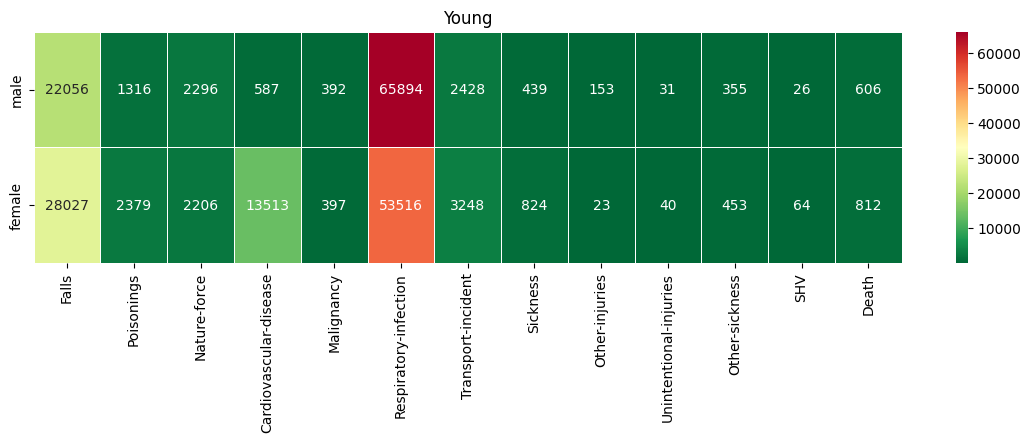

In [45]:
plt.figure(figsize=(14,3))
sns.heatmap(dataYoung, annot=True ,fmt="g", cmap='RdYlGn_r', linewidths=0.5).set_title("Young")
print()

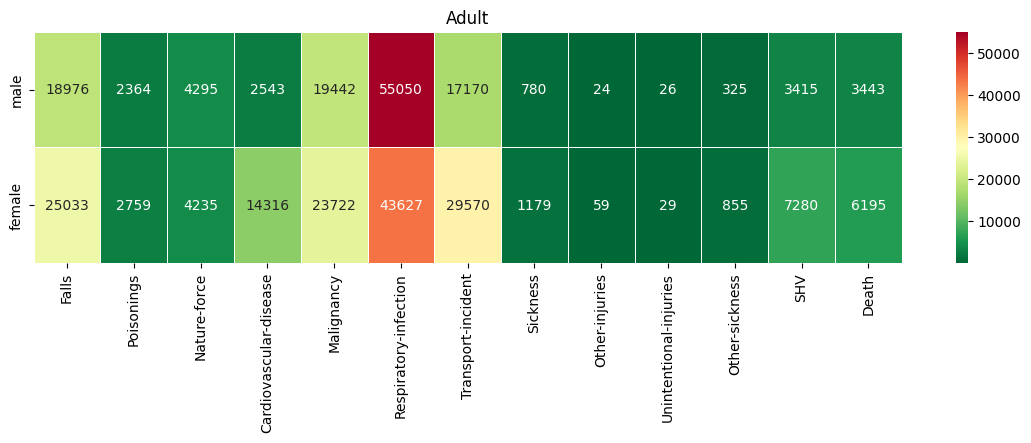

In [46]:
plt.figure(figsize=(14,3))
sns.heatmap(dataAdult, annot=True ,fmt="g", cmap='RdYlGn_r', linewidths=0.5).set_title("Adult")
print()

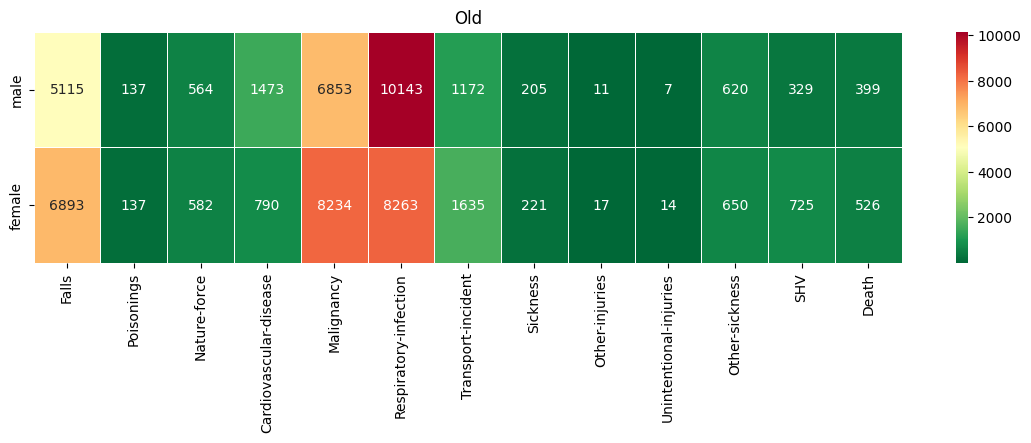

In [47]:
plt.figure(figsize=(14,3))
sns.heatmap(dataOld, annot=True ,fmt="g", cmap='RdYlGn_r', linewidths=0.5).set_title("Old")
print()

#### Heatmap - Conclusions
As can be seen from the heatmaps above, the main events affecting people in all the ages considered is "Respiratory infection". In fact, this effect is the one with the highest probability in the dataset constructor.

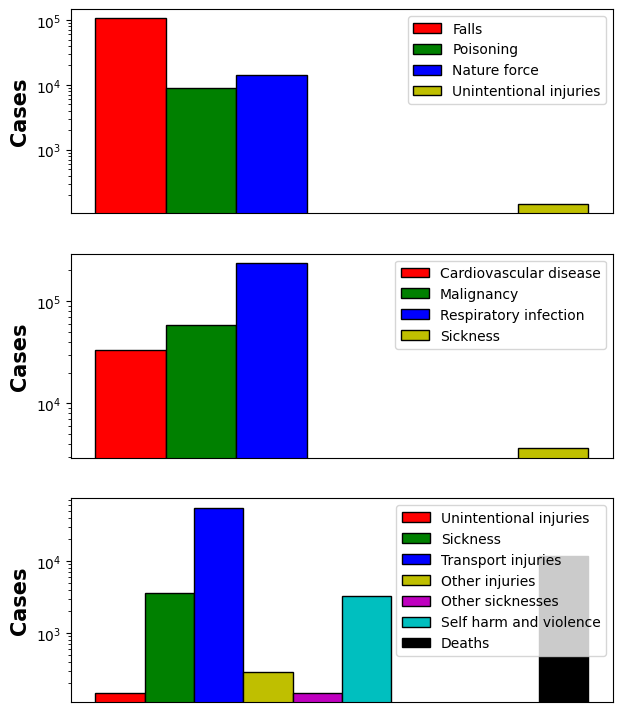

In [48]:
events_heatmap  = dataset.drop(["ID","Age-range","Gender"],axis=1).sum()

events = np.array(events_heatmap.axes)[0]
values = np.array(events_heatmap)

bar_width = 0.05
large_bar = 0.2
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize =(7, 9))

############################################################# #1

falls = [values[0]]
poisonings = [values[1]]
nature = [values[2]]
unintentional = [values[9]]

br1 = np.arange(len(falls))
br2 = [x + bar_width for x in br1]
br3 = [x + bar_width for x in br2]
br4 = [x + large_bar for x in br3]

ax1.bar(br1, falls, color ='r', width = bar_width,
        edgecolor ='black', label ='Falls')
ax1.bar(br2, poisonings, color ='g', width = bar_width,
        edgecolor ='black', label ='Poisoning')
ax1.bar(br3, nature, color ='b', width = bar_width,
        edgecolor ='black', label ='Nature force')
ax1.bar(br4, unintentional, color ='y', width = bar_width,
        edgecolor ='black', label ='Unintentional injuries')

ax1.set_ylabel('Cases', fontweight ='bold', fontsize = 15)
ax1.set_xticks([],labels=[]) 
ax1.set_yscale("log")
ax1.legend()

############################################################# #2

cardiovascular = [values[3]]
malignancy = [values[4]]
respiratory = [values[5]]
sickness = [values[7]]

br1 = np.arange(len(cardiovascular))
br2 = [x + bar_width for x in br1]
br3 = [x + bar_width for x in br2]
br4 = [x + large_bar for x in br3]

ax2.bar(br1, cardiovascular, color ='r', width = bar_width,
        edgecolor ='black', label ='Cardiovascular disease')
ax2.bar(br2, malignancy, color ='g', width = bar_width,
        edgecolor ='black', label ='Malignancy')
ax2.bar(br3, respiratory, color ='b', width = bar_width,
        edgecolor ='black', label ='Respiratory infection')
ax2.bar(br4, sickness, color ='y', width = bar_width,
        edgecolor ='black', label ='Sickness')

ax2.set_ylabel('Cases', fontweight ='bold', fontsize = 15)
ax2.set_xticks([],labels=[]) 
ax2.set_yscale("log")
ax2.legend()

############################################################# #3

# unintentional
# sickness 
transport = [values[6]]
oth_inj = [values[8]]
oth_sick = [values[9]]
shv = [values[10]]
death = [values[11]]


br1 = np.arange(len(unintentional))
br2 = [x + bar_width for x in br1]
br3 = [x + bar_width for x in br2]
br4 = [x + bar_width for x in br3]
br5 = [x + bar_width for x in br4]
br6 = [x + bar_width for x in br5]
br7 = [x + large_bar for x in br6]

ax3.bar(br1, unintentional, color ='r', width = bar_width,
        edgecolor ='black', label ='Unintentional injuries')
ax3.bar(br2, sickness, color ='g', width = bar_width,
        edgecolor ='black', label ='Sickness')
ax3.bar(br3, transport, color ='b', width = bar_width,
        edgecolor ='black', label ='Transport injuries')
ax3.bar(br4, oth_inj, color ='y', width = bar_width,
        edgecolor ='black', label ='Other injuries')
ax3.bar(br5, oth_sick, color ='m', width = bar_width,
        edgecolor ='black', label ='Other sicknesses')
ax3.bar(br6, shv, color ='c', width = bar_width,
        edgecolor ='black', label ='Self harm and violence')
ax3.bar(br7, death, color ='k', width = bar_width,
        edgecolor ='black', label ='Deaths')

ax3.set_ylabel('Cases', fontweight ='bold', fontsize = 15)
ax3.set_xticks([],labels=[]) 
ax3.set_yscale("log")
ax3.legend()
plt.show()



In [49]:
# estimator = HillClimbSearch(dataset.drop(np.arange(500,10000,9500)))

# hillclimb_model = estimator.estimate( scoring_method=BDsScore(dataset) )
# hillclimb_model = BayesianNetwork(hillclimb_model)
# draw_graph(hillclimb_model,"hillclimb_model")

In [50]:
# Parameter estimation on manual model




In [51]:
mc_model.cpds = []

d = data=dataset.drop("ID",axis=1)

mc_model.fit(data=d,
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10,
            complete_samples_only=False,
)

print(f"Check model: {mc_model.check_model()=}")

for cpd in mc_model.get_cpds():
    print(f"CPT of {cpd.variable}")
    print(cpd)
    pass

Check model: mc_model.check_model()=True
CPT of Age-range
+------------------+-----------+
| Age-range(adult) | 0.599497  |
+------------------+-----------+
| Age-range(old)   | 0.0817035 |
+------------------+-----------+
| Age-range(young) | 0.318799  |
+------------------+-----------+
CPT of Other-injuries
+-------------------+-----+------------------------+
| Age-range         | ... | Age-range(young)       |
+-------------------+-----+------------------------+
| Gender            | ... | Gender(male)           |
+-------------------+-----+------------------------+
| Other-injuries(0) | ... | 0.9998516994414357     |
+-------------------+-----+------------------------+
| Other-injuries(1) | ... | 0.00014830055856420167 |
+-------------------+-----+------------------------+
CPT of Falls
+------------------------+-----+---------------------------+
| Age-range              | ... | Age-range(young)          |
+------------------------+-----+---------------------------+
| Cardiovascular

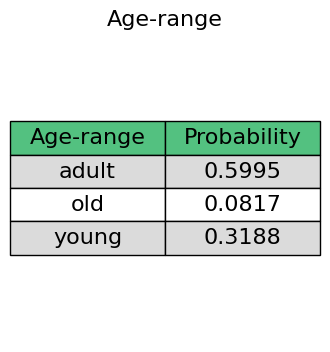

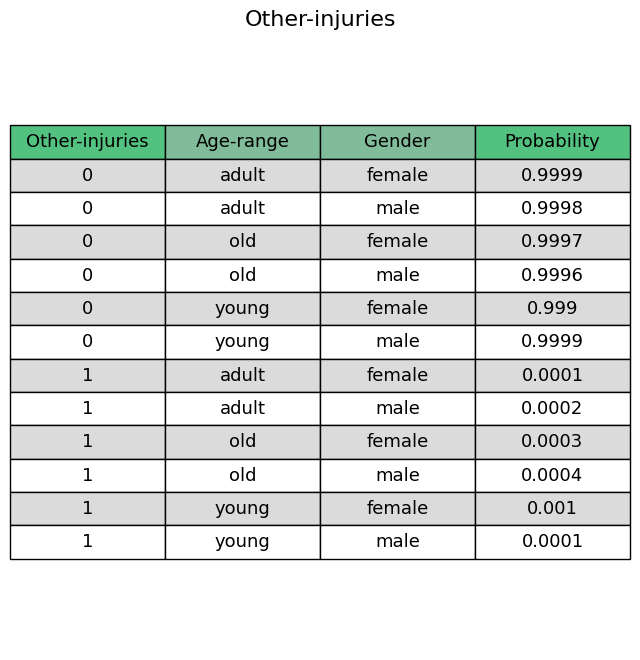

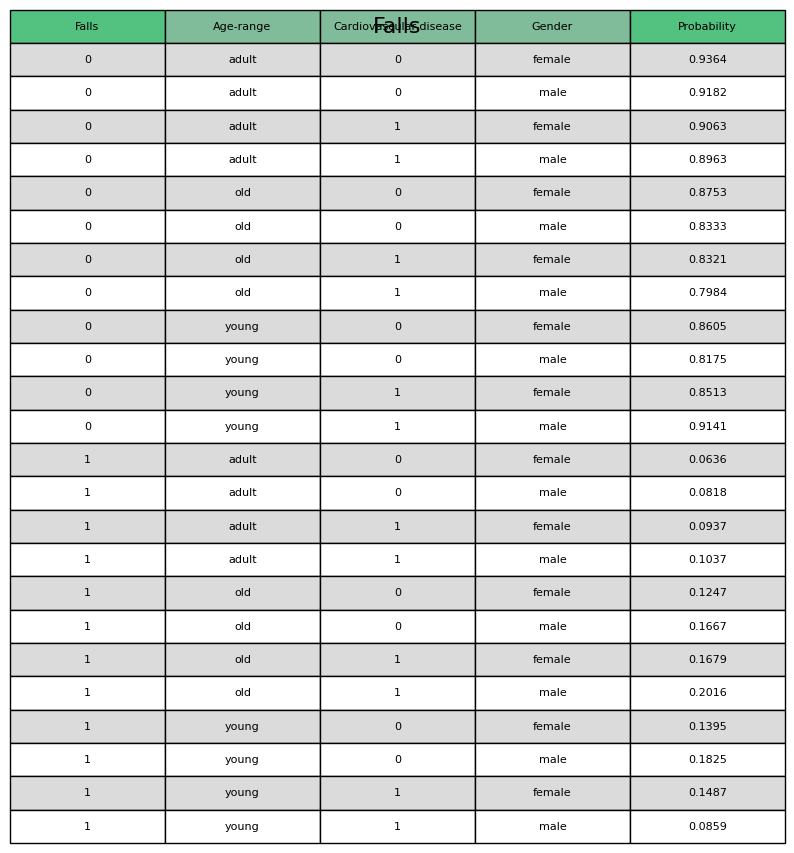

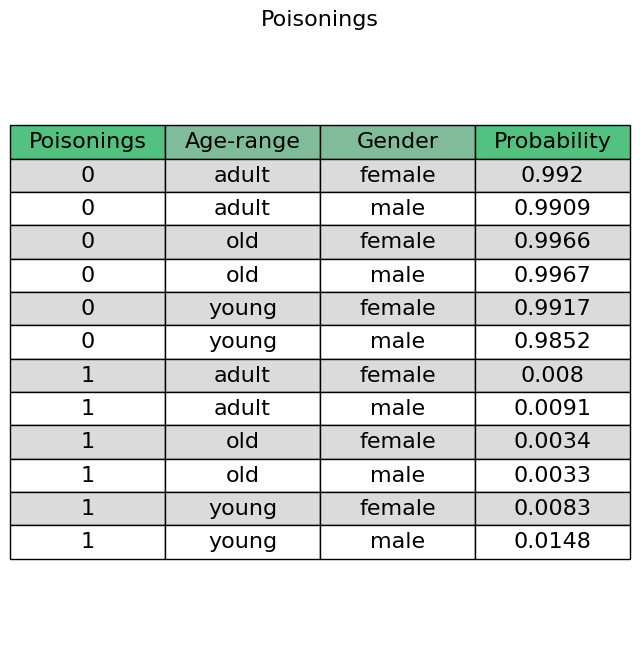

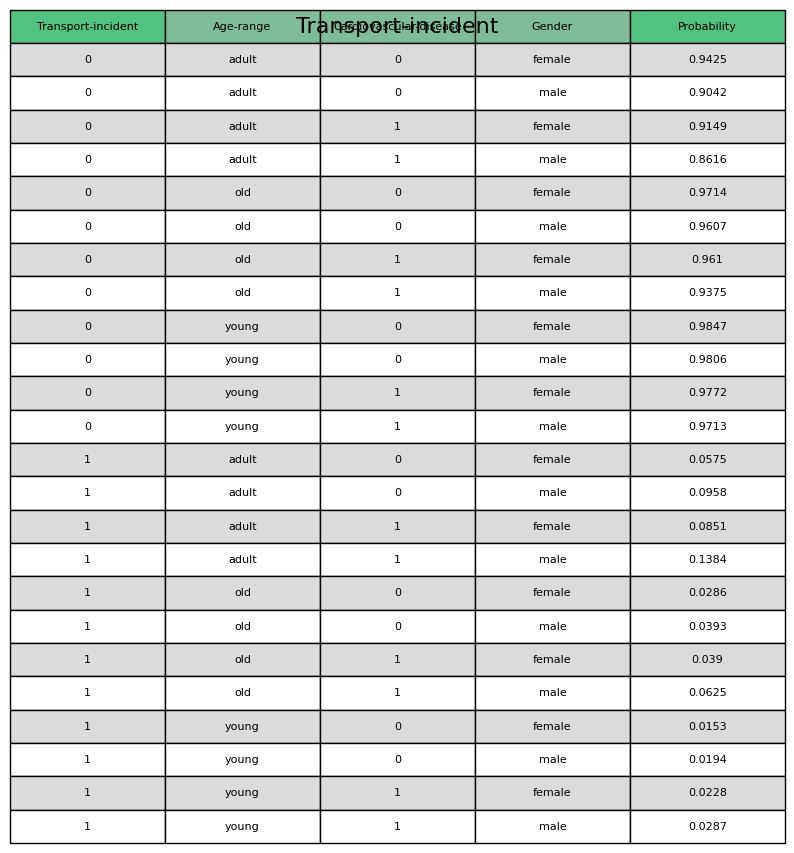

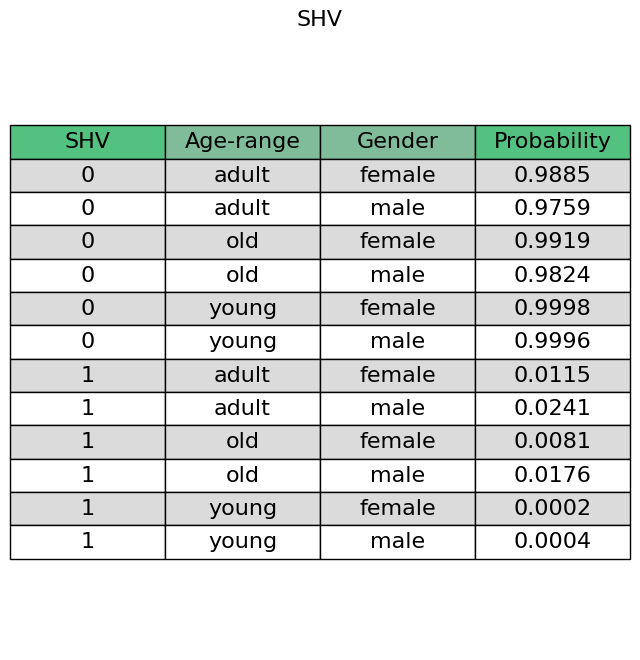

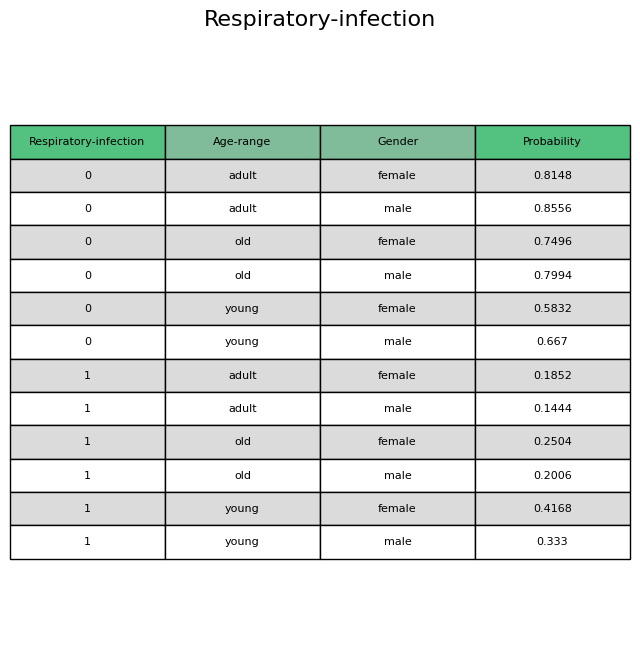

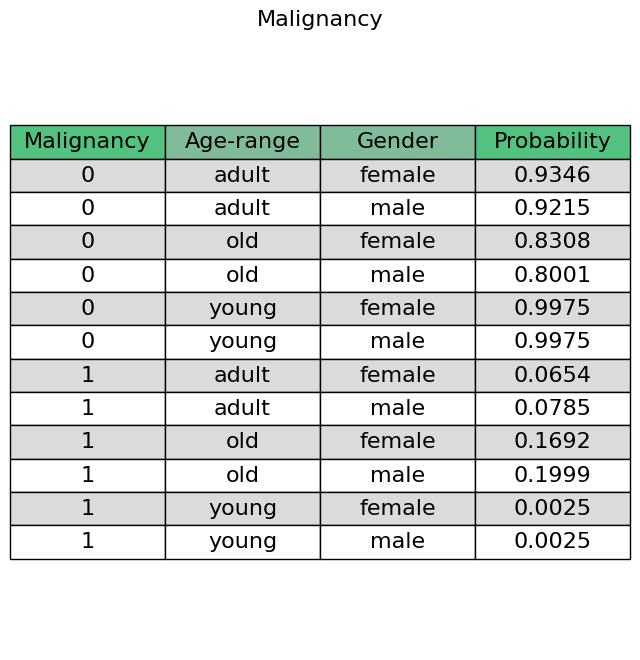

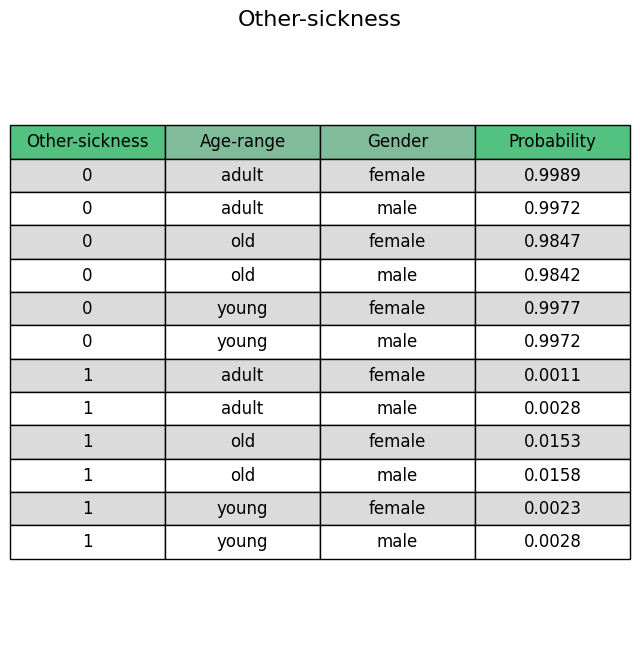

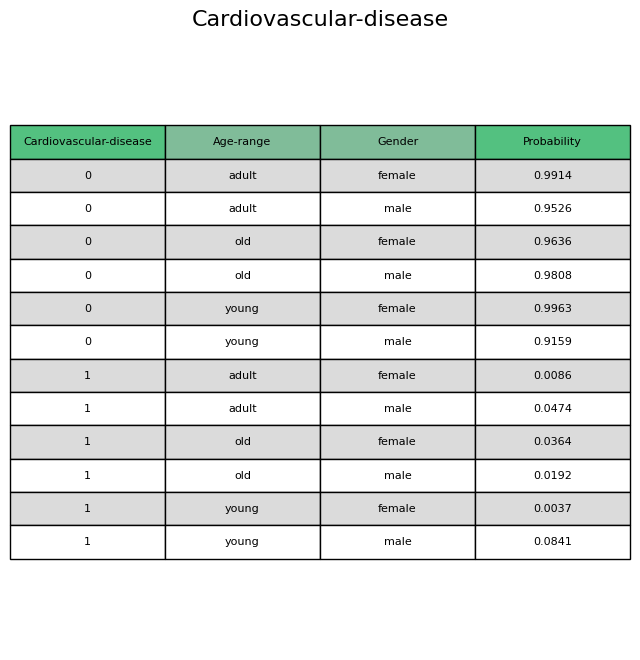

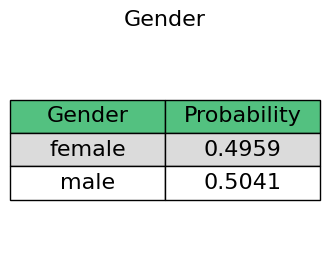

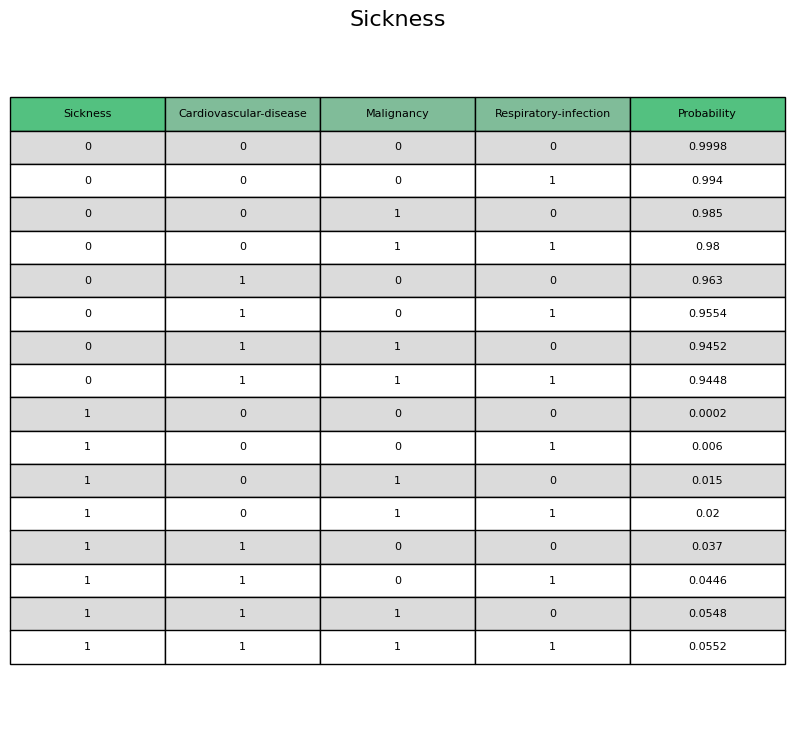

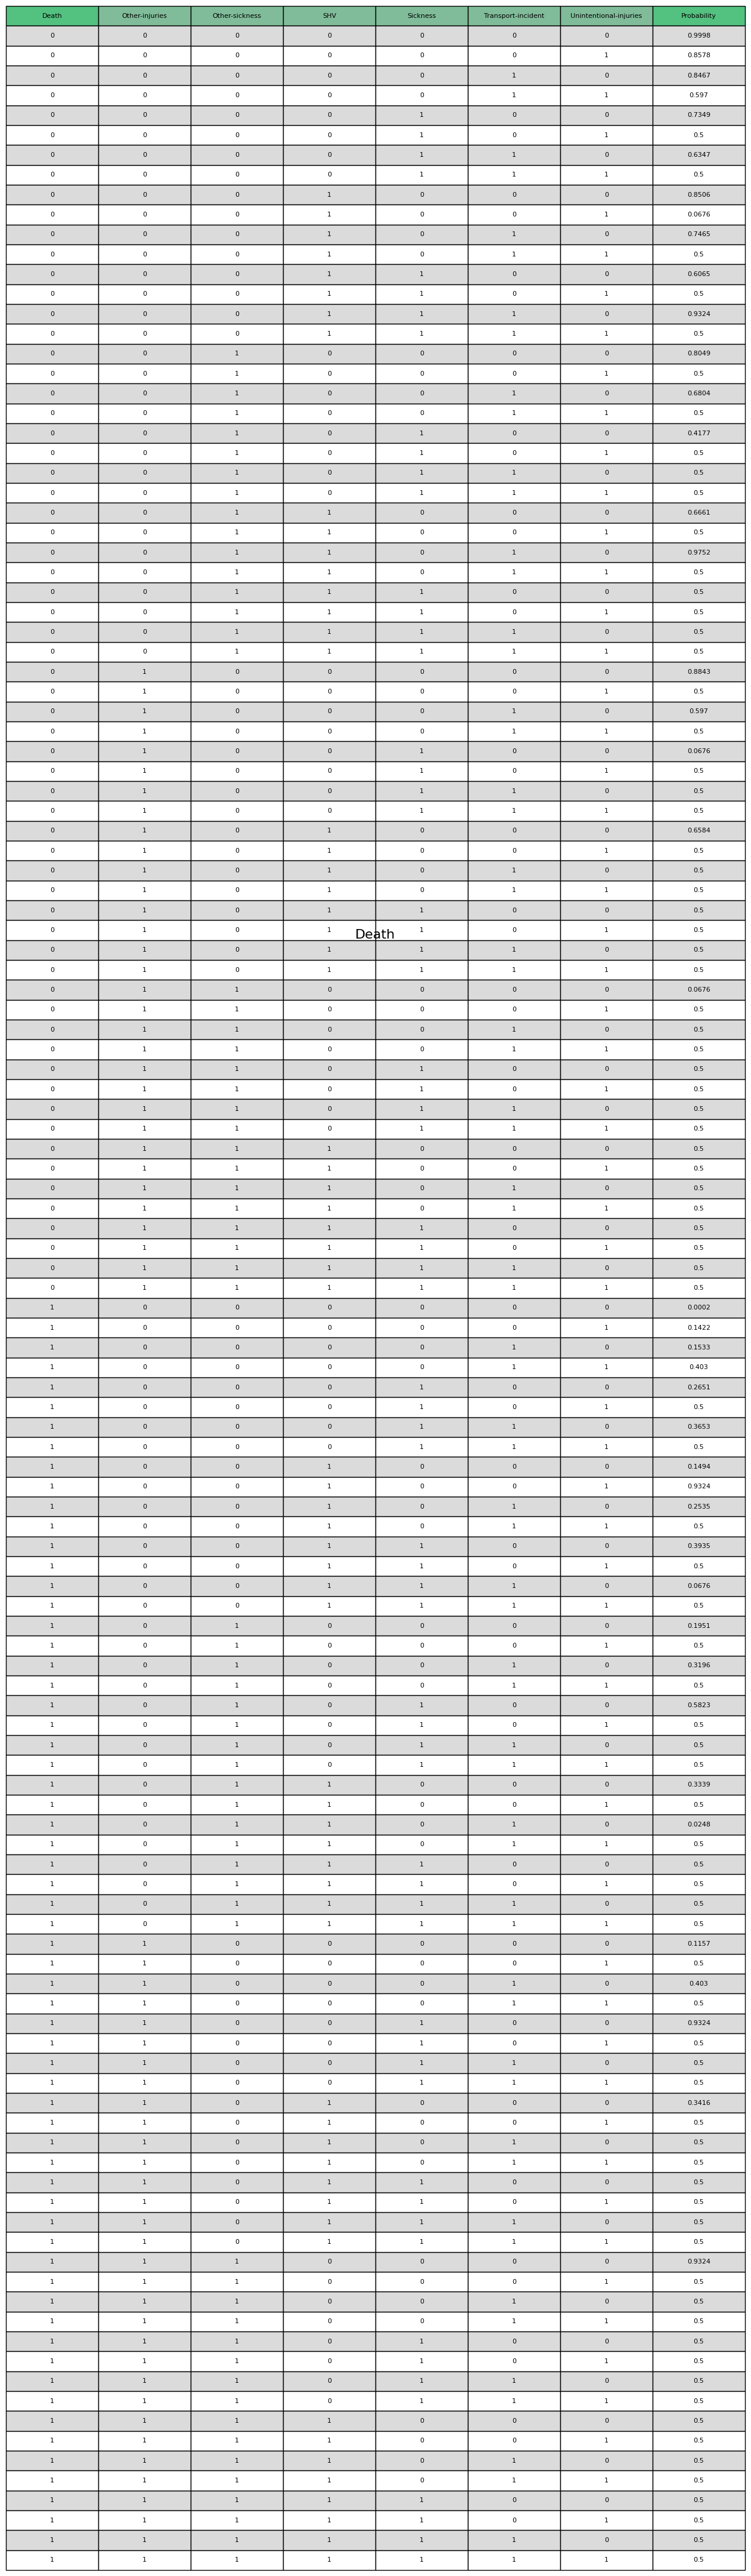

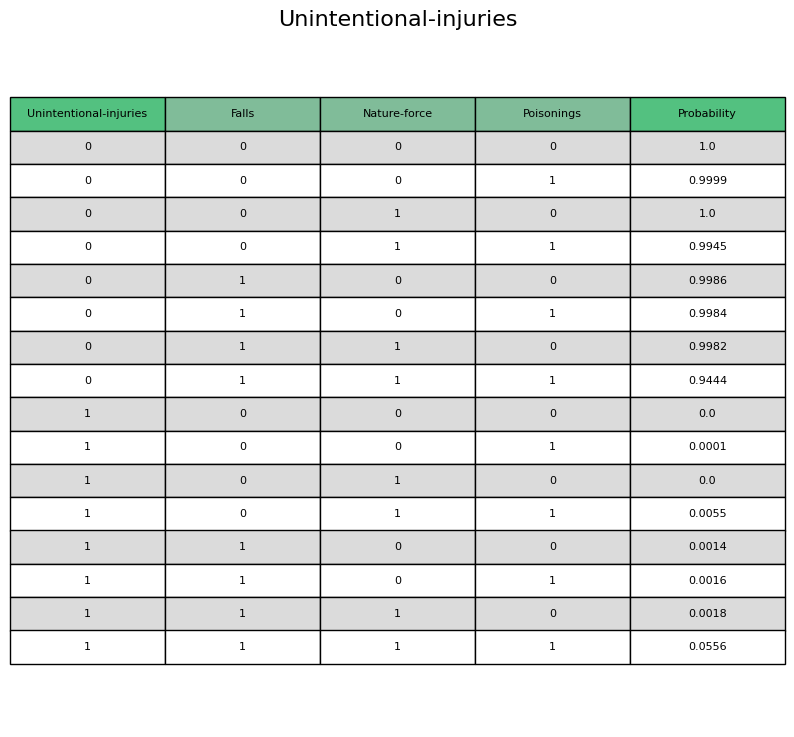

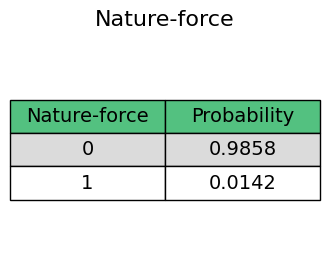

In [52]:
def print_cpd_table(cpd):
    #Getting a list of lists of states for every variable of cpd
    states_list = []
    for variable in cpd.state_names.keys():
        states_list.append(cpd.state_names[variable])

    rows = []
    i= 0

    #Create combinations of states of every evidence
    states_combos = list(itertools.product(*states_list))
    #Getting a plain array of all probabilities for simplicity
    values = cpd.values.flatten()

    #Creating a row for every possibile combination of states, concatenating the probabilities
    for combo in states_combos:
        row = []
        for elem in combo:
            row += [str(elem)]
        row += [str(round(values[i], 4))]
        rows.append(row)
        i+=1

    #Getting columns names for every variable
    col_labels = []
    for state in cpd.state_names.keys():
        col_labels+= [state]
    col_labels += ["Probability"]

    #Calculating figsize
    calculated_width = len(list(cpd.state_names.keys()))+1
    calculated_length = sum([len(cpd.state_names[var]) for var in cpd.state_names.keys()])+1
    
    #Getting colors for first row
    col_colours = np.full(calculated_width, "#80bc99")
    col_colours[0] = col_colours[calculated_width-1] = "#53c180"
    
    #Plotting the constructed table
    fig, ax1 = plt.subplots(figsize=(calculated_width, calculated_length))
    table = ax1.table(cellText = rows,
                      cellLoc = "center",
                      colLabels = col_labels,
                      colColours = col_colours,
                      loc = "center")
    
    #Visual Fixing
    for i in range(1, len(rows)+1):
        if i%2:
            for j in range(0, len(cpd.state_names.keys())+1):
                table[(i, j)].set_facecolor("#dbdbdb")

    table.scale(2, 2)
    table.set_fontsize(16)
    ax1.axis("off")
    ax1.set_title(cpd.variable, fontsize=16)

for cpd in mc_model.get_cpds():
    print_cpd_table(cpd)
    pass

In [53]:

def getPossibleGroups(evidences):
    values = []
    for evidence in evidences:
        values.append(evidence["values"])
    return list(itertools.product(*values))

# elements: array of tuples where the first element is the node of the query and the other elements are the evidences to use

def completeQueriesGenerator(model,elements):
    all_states = model.states
    all_queries = []
    for element in elements:
        node = element[0]
        queries = []
        evidences = []
        for i in range(1,len(element)):
            evidences.append({"evidence":element[i],"values":all_states[element[i]]})

        groups = getPossibleGroups(evidences)
        for group in groups: 
            evidences_obj = {}
            for evidence_value in zip(evidences, group): 
                curr_key = evidence_value[0]['evidence']
                evidences_obj[curr_key] = evidence_value[1]
            queries.append(([node], evidences_obj))        
        all_queries = all_queries + queries
    return all_queries

#q = completeQueriesGenerator(mc_model,(("Other-injuries","Age-range","Gender"),))

In [54]:
allStates = mc_model.states

# Inference
def inference(model, target, evidence):
    model_inference = VariableElimination(model)
    return model_inference.query(target, evidence)


def plot_tables(models, targets, evidences):
    #Getting tables given targets and evidences
    title = f"P({', '.join(targets)} | {', '.join([f'{key}={value}' for (key, value) in evidences.items()])})"
    
    #Getting all models names and columns labels
    model_names = [model.name for model in models]
    col_labels = targets + model_names

    #Constructing header columns colours array
    col_colours = np.full(len(targets) + len(models), "#80bc99")

    #Getting a list of all targets states
    targets_values = {}
    for target in targets:
        targets_values[target] = mc_model.states[target]

    #Calculating all probabilites for targets, given evidences, with every given model
    query_by_model = {}
    for model in models:
        query_by_model[model] = inference(model.model, targets, evidences)
    
    #Generating all possible combinations of values
    rows = []
    targets_combinations = list(itertools.product(*targets_values.values()))
    
    #For every combination and every model, generating a row with calculated probability
    for combo in targets_combinations:
        row = [*combo]
        combo_queries = [round(query_by_model[this_model].get_value(**dict(zip(targets_values.keys(), combo))), 4) for this_model in query_by_model.keys()] 
        row += combo_queries
        rows.append(row)
    
    #Plotting the table of inference
    fig, ax1 = plt.subplots(figsize=(len(targets_combinations), len(targets)+len(models)))
    table = ax1.table(cellText = rows,
                      cellLoc = "center",
                      colLabels = col_labels,
                      colColours = col_colours,
                      loc = "center")
    
    #Visual Fixing
    for i in range(1, len(rows)+1):
        if not i%2:
            for j in range(0, len(targets) + len(models)):
                table[(i, j)].set_facecolor("#dbdbdb")

    table.scale(2, 2)
    table.set_fontsize(12)
    ax1.axis("off")
    ax1.set_title(title)



In [55]:
def print_queries(model, queries):
    handWrittenQueries = [
        #(["X"], {"evidence": "value"}),   
    ]
    queries = queries + handWrittenQueries
    for query in queries:
        plot_tables(model, *query)

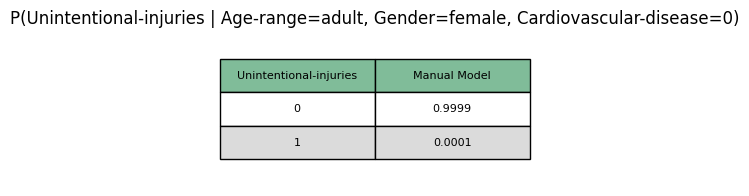

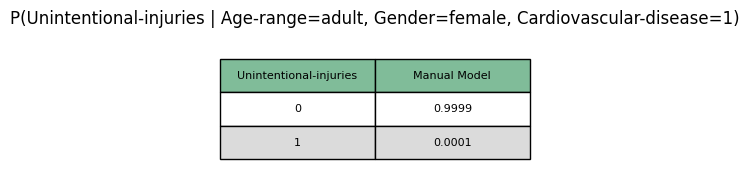

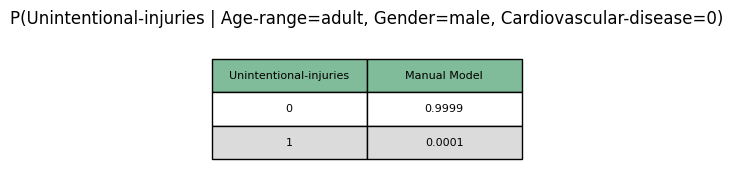

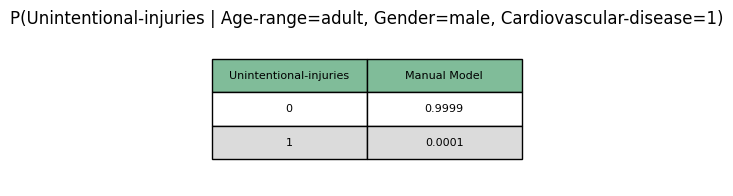

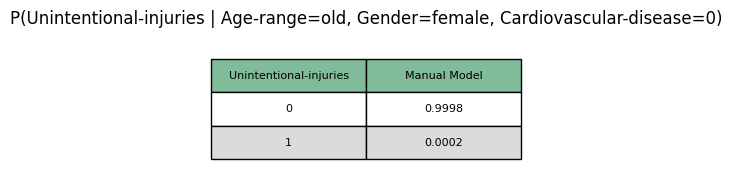

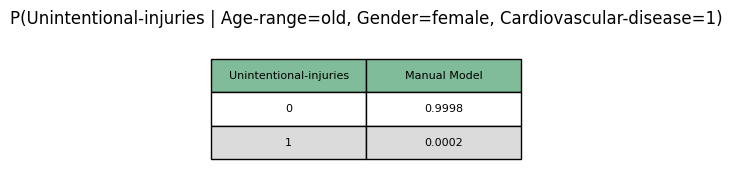

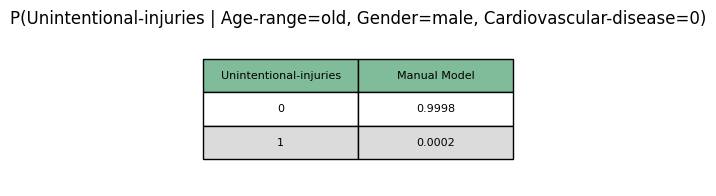

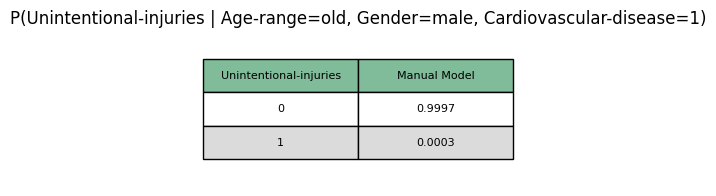

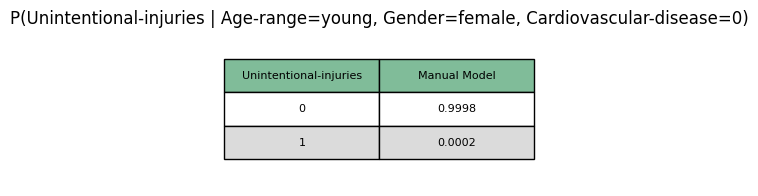

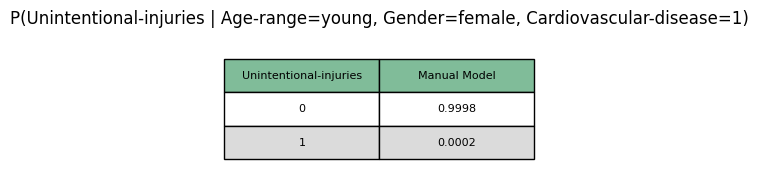

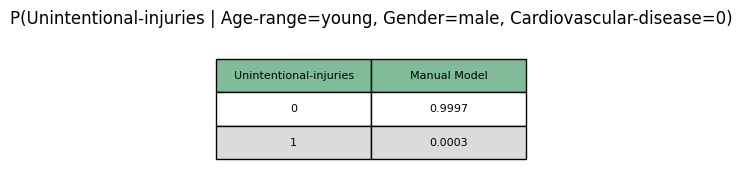

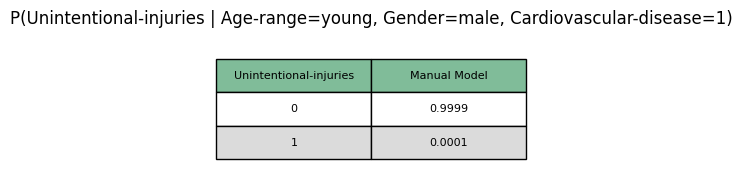

In [56]:
class Model:
    def __init__(self, model, name, dataset):
        self.model = model
        self.name = name
        self.dataset = dataset

models = [
    Model(model=mc_model, name="Manual Model", dataset=dataset),
    #Model(model=hillclimb_model, name="HillClimb Model", dataset=dataset),
]

q = completeQueriesGenerator(mc_model,(("Unintentional-injuries","Age-range","Gender","Cardiovascular-disease"),))
print_queries(models, q)

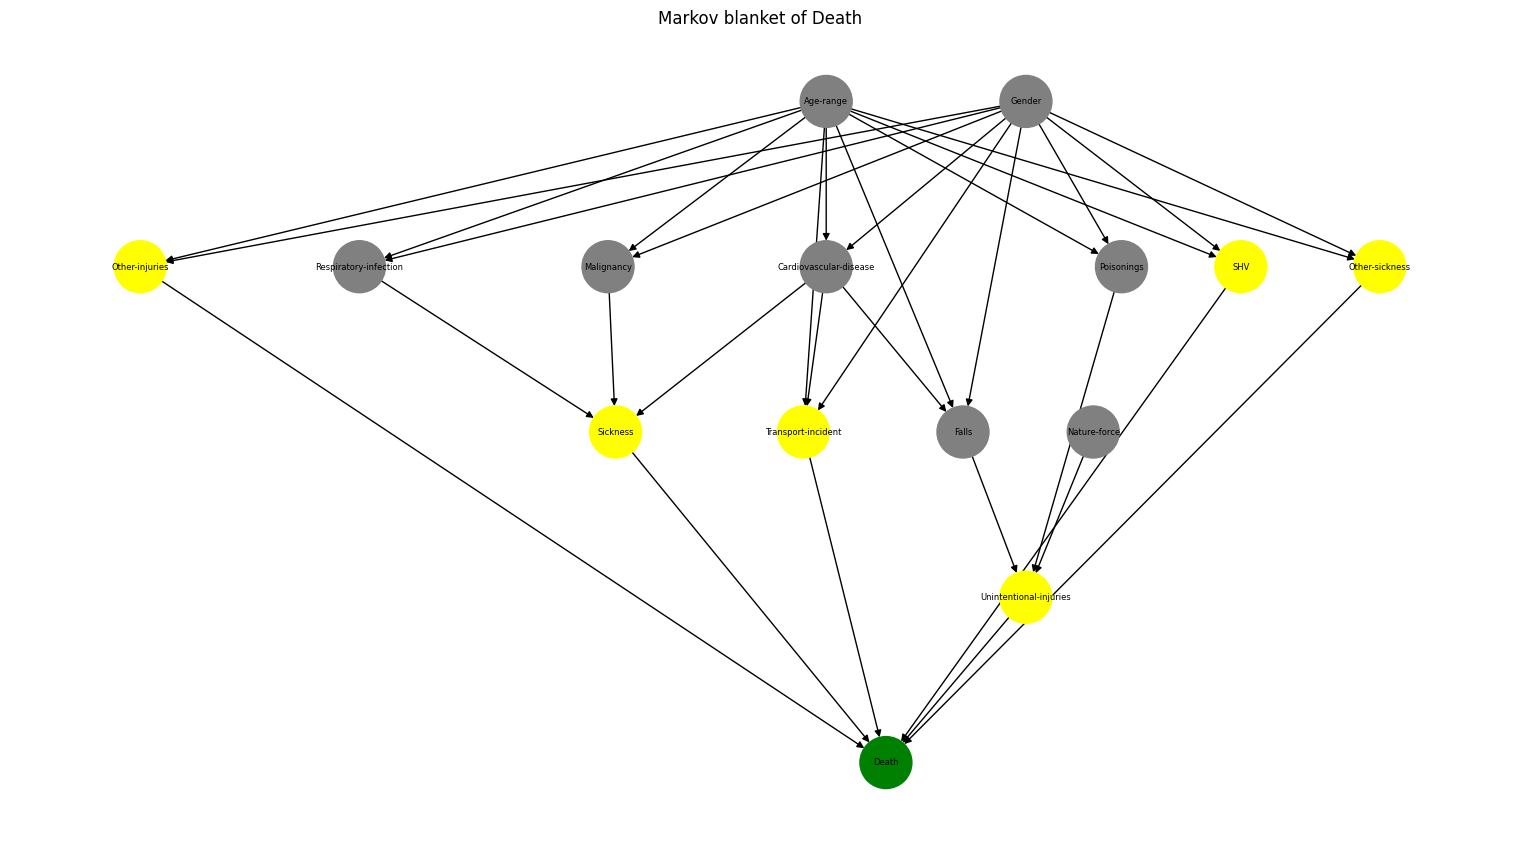

In [71]:
def markov_blanket_graph(node, model):
    blanket = model.get_markov_blanket(node)
    color = ["green" if n == node else "yellow" if n in blanket else "grey" for n in model.nodes]
    title = f'Markov blanket of {node}'
    draw_graph(model, title, color, title)

markov_blanket_graph("Death", mc_model)

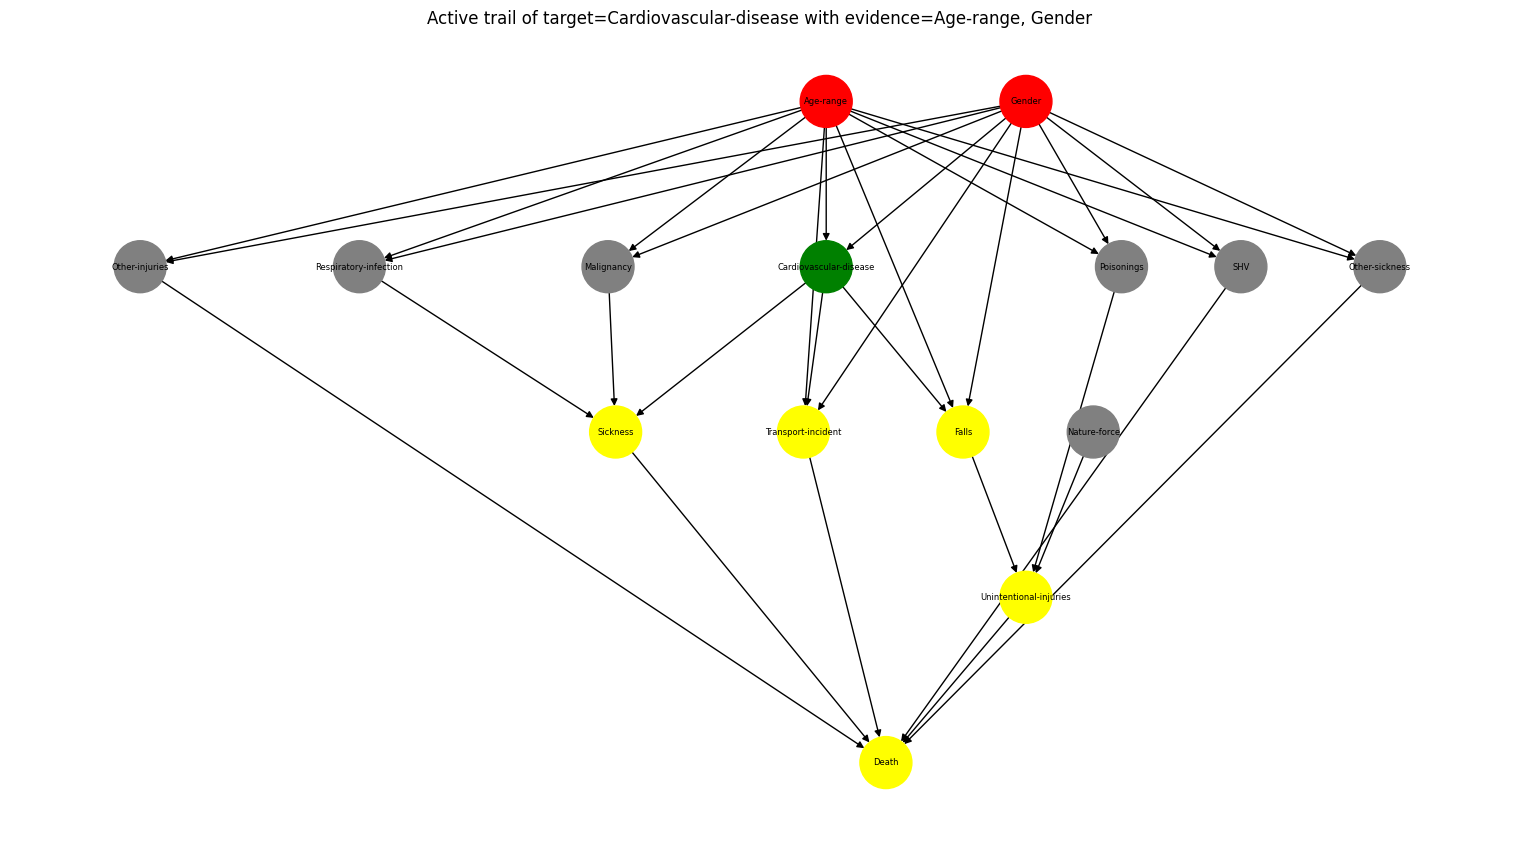

In [77]:
def active_trail_graph(target, evidences, model):
    trail_nodes = model.active_trail_nodes(target, observed=evidences).get(target)
    trail_nodes.remove(target)
    color = ["green" if n == target else "yellow" if n in trail_nodes else "red" if n in evidences else "grey" for n in model.nodes]
    title=f"Active trail of target={target} {'with evidence='+', '.join(evidences) if len(evidences) != 0 else 'with no evidence'}"
    draw_graph(model, title, color, title)

active_trail_graph("Cardiovascular-disease", ["Age-range", "Gender"], mc_model)

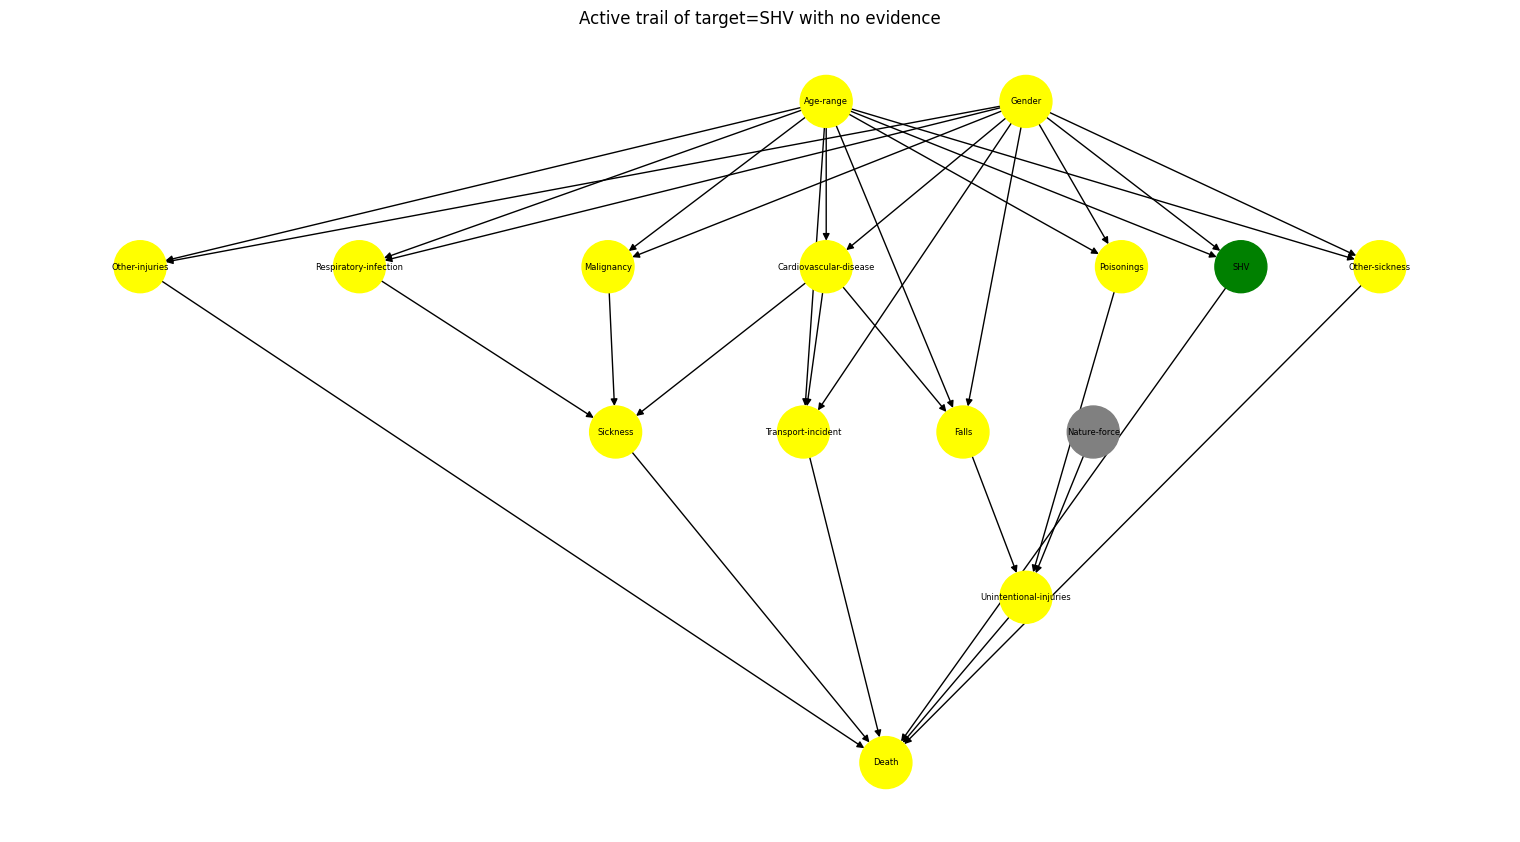

In [78]:
def dependency_graph(node, model):
    active_trail_graph(node, [], model)

dependency_graph("SHV", mc_model)